<h1 style="color: salmon">K-Medoids Clustering</h1>
Nothing.

In [1]:
import pandas as pd
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn_extra.cluster import KMedoids
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

In [2]:
df = pd.read_csv("../data/lastest.csv", encoding="utf-8")
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
df.shape

(594643, 10)

<h2 style="color: salmon;">Data Pre-Processing</h2>

In [4]:
# Remove the uneccesary single quotes
df['category'] = df['category'].str.strip("'").str.split('_').str[1]
df['customer'] = df['customer'].str.strip("'")
df['age'] = df['age'].str.strip("'")
df['gender'] = df['gender'].str.strip("'")
df['merchant'] = df['merchant'].str.strip("'")

# Add the age label as in the original paper
age_map = {
    "0": "<=18", "1": "19-25", "2": "26-35", "3": "36-45", 
    "4": "46-55", "5": "56-65", "'6'": ">65", "U": "Unknown"
}
df['age_labeled'] = df['age'].map(age_map)

# Convert from step to hour of day (ex: 2 means 2AM)
def step_to_hour(row):
    return row % 24

df["hour_of_day"] = df["step"].apply(step_to_hour)

# Drop noise cols:
df = df.drop(
    columns=[
        'zipcodeOri',
        'zipMerchant'
    ],
    errors="ignore"
)

df.head()

,step,customer,age,gender,merchant,category,amount,fraud,age_labeled,hour_of_day
0,0,C1093826151,4,M,M348934600,transportation,4.55,0,46-55,0
1,0,C352968107,2,M,M348934600,transportation,39.68,0,26-35,0
2,0,C2054744914,4,F,M1823072687,transportation,26.89,0,46-55,0
3,0,C1760612790,3,M,M348934600,transportation,17.25,0,36-45,0
4,0,C757503768,5,M,M348934600,transportation,35.72,0,56-65,0


<h2 style="color:salmon">Feature Engineering</h2>

### Spending velocity and Spending Frequency: The amount of money that a customer spend as well as the transaction frequency in a period of time

In [5]:
df = df.sort_values(by=['customer', 'step'])
df = df.reset_index(drop=True)

# Create a temporary 'TimeDelta' column => we can then do time math on this col
df['temp_time'] = pd.to_timedelta(df['step'], unit='h')

# Spending
df['spending_vel_3h'] = (
    df.groupby('customer')
    .rolling('3h', on='temp_time')['amount']
    .sum()
    .values
)

df['spending_vel_6h'] = (
    df.groupby('customer')
    .rolling('6h', on='temp_time')['amount']
    .sum()
    .values
)

df['spending_vel_24h'] = (
    df.groupby('customer')
    .rolling('24h', on='temp_time')['amount']
    .sum()
    .values
)

# Frequency
df['frequency_3h'] = (
    df.groupby('customer')
    .rolling('3h', on='temp_time')['amount']
    .count()
    .values
)

df['frequency_6h'] = (
    df.groupby('customer')
    .rolling('6h', on='temp_time')['amount']
    .count()
    .values
)

df['frequency_24h'] = (
    df.groupby('customer')
    .rolling('24h', on='temp_time')['amount']
    .count()
    .values
)

In [6]:
df.head()

,step,customer,age,gender,merchant,category,amount,fraud,age_labeled,hour_of_day,temp_time,spending_vel_3h,spending_vel_6h,spending_vel_24h,frequency_3h,frequency_6h,frequency_24h
0,30,C1000148617,5,M,M1888755466,otherservices,143.87,0,56-65,6,1 days 06:00:00,143.87,143.87,143.87,1.0,1.0,1.0
1,38,C1000148617,5,M,M1741626453,sportsandtoys,16.69,0,56-65,14,1 days 14:00:00,16.69,16.69,160.56,1.0,1.0,2.0
2,42,C1000148617,5,M,M1888755466,otherservices,56.18,0,56-65,18,1 days 18:00:00,56.18,72.87,216.74,1.0,2.0,3.0
3,43,C1000148617,5,M,M840466850,tech,14.74,0,56-65,19,1 days 19:00:00,70.92,87.61,231.48,2.0,3.0,4.0
4,44,C1000148617,5,M,M1823072687,transportation,47.42,0,56-65,20,1 days 20:00:00,118.34,118.34,278.90,3.0,3.0,5.0


### High risk Categories and Merchants (Target Encoding using Means)

In [7]:
category_risk_map = df.groupby('category')['fraud'].mean()

df['category_risk_score'] = df['category'].map(category_risk_map)

In [8]:
merchant_risk_map = df.groupby('merchant')['fraud'].mean()

df['merchant_risk_score'] = df['merchant'].map(merchant_risk_map)

### Age and Gender targeting

In [9]:
age_risk_map = df.groupby('age')['fraud'].mean()

df['age_risk_score'] = df['age'].map(age_risk_map)

In [10]:
# According to the EDA, no cases of Enterprise were Fraud
df['is_enterprise'] = df["gender"].apply(lambda g: 1 if g == "E" else 0)
df['is_enterprise'].value_counts()

is_enterprise
0    593465
1      1178
Name: count, dtype: int64

In [11]:
df.head()

,step,customer,age,gender,merchant,category,amount,fraud,age_labeled,hour_of_day,...,spending_vel_3h,spending_vel_6h,spending_vel_24h,frequency_3h,frequency_6h,frequency_24h,category_risk_score,merchant_risk_score,age_risk_score,is_enterprise
0,30,C1000148617,5,M,M1888755466,otherservices,143.87,0,56-65,6,...,143.87,143.87,143.87,1.0,1.0,1.0,0.250000,0.250000,0.010951,0
1,38,C1000148617,5,M,M1741626453,sportsandtoys,16.69,0,56-65,14,...,16.69,16.69,160.56,1.0,1.0,2.0,0.495252,0.371212,0.010951,0
2,42,C1000148617,5,M,M1888755466,otherservices,56.18,0,56-65,18,...,56.18,72.87,216.74,1.0,2.0,3.0,0.250000,0.250000,0.010951,0
3,43,C1000148617,5,M,M840466850,tech,14.74,0,56-65,19,...,70.92,87.61,231.48,2.0,3.0,4.0,0.066667,0.112938,0.010951,0
4,44,C1000148617,5,M,M1823072687,transportation,47.42,0,56-65,20,...,118.34,118.34,278.90,3.0,3.0,5.0,0.000000,0.000000,0.010951,0


In [12]:
df.columns.to_list()

['step',
 'customer',
 'age',
 'gender',
 'merchant',
 'category',
 'amount',
 'fraud',
 'age_labeled',
 'hour_of_day',
 'temp_time',
 'spending_vel_3h',
 'spending_vel_6h',
 'spending_vel_24h',
 'frequency_3h',
 'frequency_6h',
 'frequency_24h',
 'category_risk_score',
 'merchant_risk_score',
 'age_risk_score',
 'is_enterprise']

<h2 style="color: salmon">Final Cleaning and Spliting</h2>

In [13]:
# This step also put the "fraud" col to its position
keep_cols = [
 'spending_vel_3h',
 'spending_vel_6h',
 'spending_vel_24h',
 'frequency_3h',
 'frequency_6h',
 'frequency_24h',
 'category_risk_score',
 'merchant_risk_score',
 'age_risk_score',
 'is_enterprise',
 'fraud'
]
df = df[keep_cols]

In [14]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Standardize: This transform the data to not being biased. For example, the spending vel might be a few hundred, 
# while the risk score is just 0.8 => when we calculate the Manhatt (without StandardScaler), the spending vel will pull everything to it
# because its a big number !
scaler = StandardScaler()
scaler.fit(X_train)

# the code will transform both (test and train dts) into a standardized (Numpy arr, no col names, hard to read) 
# and then transform it back into dataframes with cols name !
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [16]:
X_train_sample = X_train_scaled.sample(n=10000, random_state=42)
# We'll start with 3 clusters (Normal, Suspicious, Outlier)
# We use 'manhattan' distance because it's often more robust for fraud data
kmed = KMedoids(n_clusters=3, metric='manhattan', init='k-medoids++', random_state=42)

kmed.fit(X_train_sample)

c:\Users\Admin\Desktop\BankFraudML\.venv\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)


,n_clusters,3
,metric,'manhattan'
,method,'alternate'
,init,'k-medoids++'
,max_iter,300
,random_state,42


In [17]:
df.head()

,spending_vel_3h,spending_vel_6h,spending_vel_24h,frequency_3h,frequency_6h,frequency_24h,category_risk_score,merchant_risk_score,age_risk_score,is_enterprise,fraud
0,143.87,143.87,143.87,1.0,1.0,1.0,0.250000,0.250000,0.010951,0,0
1,16.69,16.69,160.56,1.0,1.0,2.0,0.495252,0.371212,0.010951,0,0
2,56.18,72.87,216.74,1.0,2.0,3.0,0.250000,0.250000,0.010951,0,0
3,70.92,87.61,231.48,2.0,3.0,4.0,0.066667,0.112938,0.010951,0,0
4,118.34,118.34,278.90,3.0,3.0,5.0,0.000000,0.000000,0.010951,0,0


<h2 style="color: salmon">Testing Phase</h2>

### External Validation (using Fraud col)

In [18]:
# 1. Assign a cluster ID to every row in the scaled data
# predict() will calculate the Manhatt from a new data point to 3 Medoids and then pick which one is the closest
train_clusters = kmed.predict(X_train_scaled)   # This uses the 'medoids' found in your 10k sample to label all 400k+ rows
test_clusters = kmed.predict(X_test_scaled)     # Test the kmed with "UNSEEN" data => the real testing

# 2. Add these labels back to the original DataFrames (the one that aren't standardized) so you can see them
# This makes it easy to compare 'cluster' vs 'fraud'
X_train['cluster'] = train_clusters
X_test['cluster'] = test_clusters

# Add the actual fraud labels back for comparison
X_test['is_fraud'] = y_test

In [19]:
# 3. Check how many fraud cases are in each cluster for the Test Set
test_results = X_test.groupby('cluster')['is_fraud'].agg(['count', 'sum', 'mean'])
test_results.columns = ['Total Transactions', 'Fraud Count', 'Fraud Percentage (%)']

print("--- K-Medoids Test Results ---")
print(test_results)

# Cluster 2 are the Fraudulent cases with 73% of it are fraud

--- K-Medoids Test Results ---
         Total Transactions  Fraud Count  Fraud Percentage (%)
cluster                                                       
0                     79218          361              0.004557
1                     38584          261              0.006764
2                      1127          824              0.731145


### Elbow Test: is k=3 optimal ?

c:\Users\Admin\Desktop\BankFraudML\.venv\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Admin\Desktop\BankFraudML\.venv\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Admin\Desktop\BankFraudML\.venv\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly i

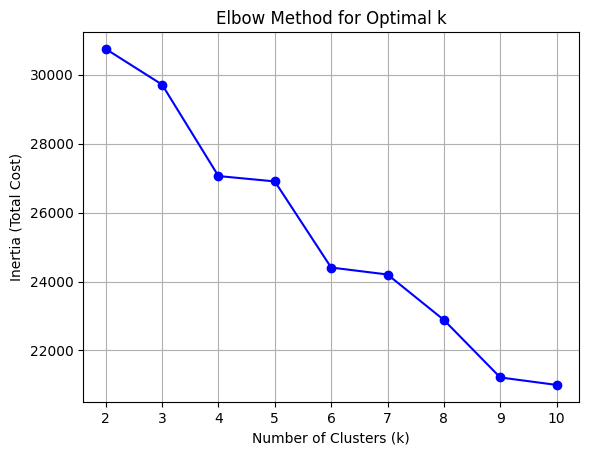

In [20]:
# The elbow test: which k number is the most optimal ?
inertias = []
k_range = range(2, 11)

for k in k_range:
    ktest = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=42)
    ktest.fit(X_train_sample)
    inertias.append(ktest.inertia_)     # inertia_: Sum of squared distances of samples to their closest cluster center

plt.plot(k_range, inertias, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Total Cost)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# => the best should be 4 ?

In [21]:
kmed4 = KMedoids(n_clusters=4, metric='manhattan', init='k-medoids++', random_state=42)
kmed4.fit(X_train_sample)

c:\Users\Admin\Desktop\BankFraudML\.venv\Lib\site-packages\sklearn\utils\deprecation.py:95: FutureWarning: Function stable_cumsum is deprecated; `sklearn.utils.extmath.stable_cumsum` is deprecated in version 1.8 and will be removed in 1.10. Use `np.cumulative_sum` with the desired dtype directly instead.
  warnings.warn(msg, category=FutureWarning)


,n_clusters,4
,metric,'manhattan'
,method,'alternate'
,init,'k-medoids++'
,max_iter,300
,random_state,42


In [22]:
# Retest the new KMedoids
train_clust_new = kmed4.predict(X_train_scaled)  
test_clust_new = kmed4.predict(X_test_scaled) 

X_train['cluster'] = train_clust_new
X_test['cluster'] = test_clust_new
X_test['is_fraud'] = y_test

test_results = X_test.groupby('cluster')['is_fraud'].agg(['count', 'sum', 'mean'])
test_results.columns = ['Total Transactions', 'Fraud Count', 'Fraud Percentage (%)']

print("--- K-Medoids Test Results ---")
print(test_results)

# BETTER WITH 85% accuracy for fraud

--- K-Medoids Test Results ---
         Total Transactions  Fraud Count  Fraud Percentage (%)
cluster                                                       
0                     76997          265              0.003442
1                     34936           61              0.001746
2                       966          826              0.855072
3                      6030          294              0.048756


### Silhouette: measures how well-separated the clusters are. For fraud detection .2 -> .4 is expected

--- Silhouette Results ---
Average Silhouette Score: 0.2832


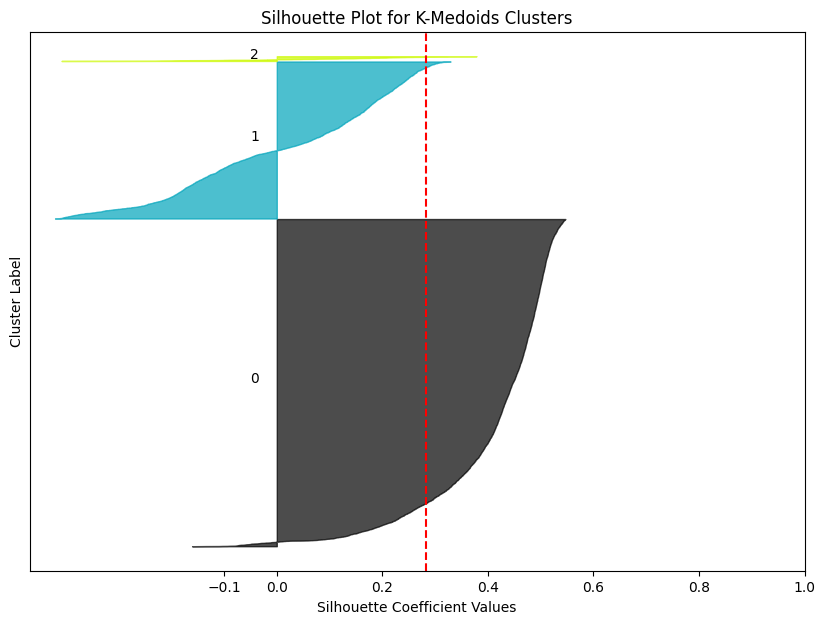

In [23]:
sample_labels = kmed.labels_
avg_silhouette = silhouette_score(X_train_sample, sample_labels, metric='manhattan')

print(f"--- Silhouette Results ---")
print(f"Average Silhouette Score: {avg_silhouette:.4f}")

# Create the Silhouette Plot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

# Get silhouette samples for each point
sample_silhouette_values = silhouette_samples(X_train_sample, sample_labels, metric='manhattan')

y_lower = 10
for i in range(kmed.n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[sample_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / kmed.n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples gap between clusters

ax1.set_title("Silhouette Plot for K-Medoids Clusters")
ax1.set_xlabel("Silhouette Coefficient Values")
ax1.set_ylabel("Cluster Label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=avg_silhouette, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

# for k=4: 0.23 while k=3 is 0.28 => the k=4 is being overlapped => STAY WITH k=3 is more stable MATHEMATICALLY

### Explain "Why": using Medoids' centers to understand the features that the model used to detect fraud

In [24]:
# 1. Get the medoid coordinates (the centers of your clusters)
scaled_medoids = kmed.cluster_centers_

# 2. Reverse the scaling to get original units (USD, counts, etc.)
# Note: Ensure 'scaler' and 'X_train' are the ones from the previous cells
original_medoids = scaler.inverse_transform(scaled_medoids)

# 3. Create a DataFrame for easy viewing
# We use the column names from X_train (excluding 'cluster' if you added it there)
feature_names = [col for col in X_train.columns if col != 'cluster']
medoid_profiles = pd.DataFrame(original_medoids, columns=feature_names)
medoid_profiles.index.name = 'Cluster'

print("--- Typical Transaction Profile per Cluster ---")
medoid_profiles

--- Typical Transaction Profile per Cluster ---


,spending_vel_3h,spending_vel_6h,spending_vel_24h,frequency_3h,frequency_6h,frequency_24h,category_risk_score,merchant_risk_score,age_risk_score,is_enterprise
Cluster,,,,,,,,,,
0,89.36,190.65,702.33,3.0,6.0,23.0,0.000000,0.000000,0.012514,0.0
1,75.16,105.81,556.03,3.0,5.0,21.0,0.000000,0.000000,0.011928,0.0
2,314.72,419.37,788.75,2.0,5.0,18.0,0.495252,0.832109,0.012514,0.0


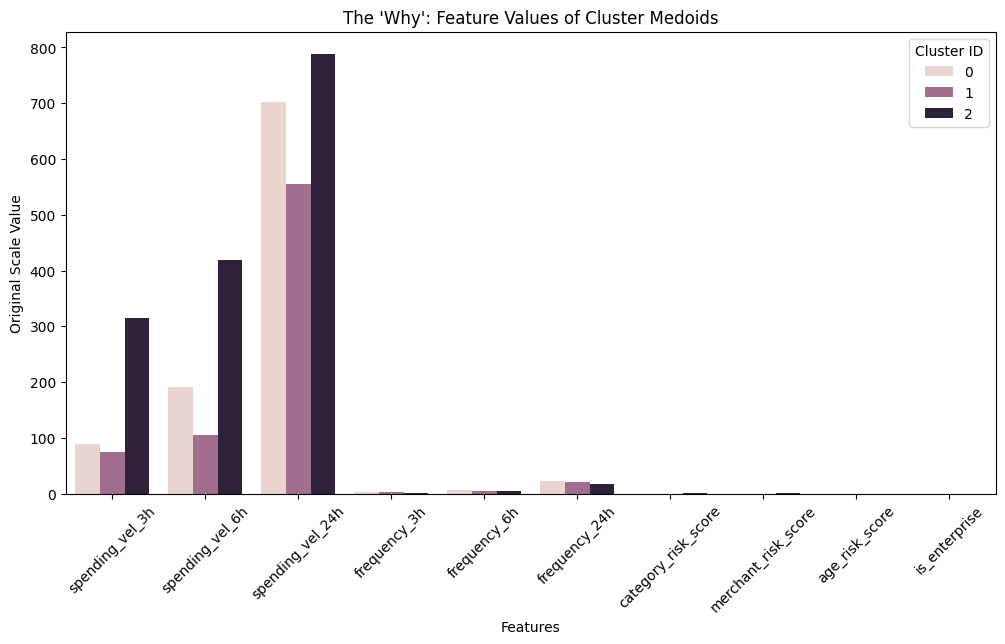

In [25]:
# We melt the dataframe to make it compatible with Seaborn's plotting
plot_data = medoid_profiles.reset_index().melt(id_vars='Cluster')

plt.figure(figsize=(12, 6))
sns.barplot(data=plot_data, x='variable', y='value', hue='Cluster')
plt.xticks(rotation=45)
plt.title("The 'Why': Feature Values of Cluster Medoids")
plt.ylabel("Original Scale Value")
plt.xlabel("Features")
plt.legend(title="Cluster ID")
plt.show()

### **Summary of K-Medoids Fraud Analysis**
The K-Medoids model successfully identified a high-risk "Fraud Magnet" (Cluster 2) that contains over 73% actual fraud cases. 
Through the Elbow Method and Silhouette Analysis, it was confirmed that $k=3$ is the most stable and effective. 
The model’s primary logic for flagging fraud is rooted in identifying <b><font color="red">extreme spending velocity</font></b> combined with <b><font color="red">high-risk merchant profiles</font></b>.

* **High-Precision Targeting**: Cluster 2 isolated 824 fraudulent transactions with a 73.11% density, allowing investigators to focus on a small, high-risk group.
* **Optimal Structure**: $k=3$ achieved the most stable silhouette score (~0.28); moving to $k=4$ caused a drop in score (0.23) and created "confused" clusters with negative coefficients.
* **Behavioral DNA**: Medoid analysis reveals that fraud is driven by rapid "spending sprees" (e.g., >$300 in 3 hours) at risky merchants rather than just a high number of transactions.
* **Mathematical Consistency**: The use of Manhattan distance and `StandardScaler` ensured that the model remained robust against outliers while weighing spending volume and transaction frequency equally.

In [27]:
# Save and done:)

joblib.dump(kmed, '../app/models/kmedoids_model.pkl')
joblib.dump(scaler, '../app/models/scaler.pkl')

['../app/models/scaler.pkl']